In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
df = pd.read_csv('data/gender-classifier-DFE-791531.csv', encoding='latin-1')
df.sample(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
7420,815726738,False,finalized,3,10/27/15 0:05,brand,1.0000,yes,1.0,4/20/09 6:36,...,https://pbs.twimg.com/profile_images/422400356...,0,0,Your Last Week to Vote Early | The Katy News h...,NaN,37175,10/26/15 12:40,6.587300e+17,"Katy, Texas",Central Time (US & Canada)
279,815719505,False,finalized,3,10/26/15 23:21,brand,0.6674,yes,1.0,9/27/10 11:30,...,https://pbs.twimg.com/profile_images/113421566...,0,181A1E,"I posted 67 photos on Facebook in the album ""B...",NaN,299,10/26/15 12:40,6.587300e+17,"Portland, OR",Pacific Time (US & Canada)
5520,815724829,False,finalized,3,10/26/15 22:29,brand,1.0000,yes,1.0,4/17/13 16:58,...,https://abs.twimg.com/sticky/default_profile_i...,0,C0DEED,Get Weather Updates from The Weather Channel. ...,NaN,36423,10/26/15 12:40,6.587300e+17,NaN,NaN
475,815719702,False,finalized,3,10/26/15 22:47,brand,1.0000,yes,1.0,5/6/10 11:01,...,https://pbs.twimg.com/profile_images/521705666...,0,0,_Ù_Ä_Ù_Ä_Ù_Ä // Our favorite little boy @ponch...,NaN,5891,10/26/15 12:40,6.587300e+17,LA,Pacific Time (US & Canada)
17551,815737086,False,finalized,3,10/27/15 0:44,female,1.0000,yes,1.0,7/6/11 15:07,...,https://pbs.twimg.com/profile_images/657050250...,0,EEEEEE,"A little girl just ran into GR's screaming ""IC...",NaN,50142,10/26/15 13:19,6.587400e+17,NaN,Central Time (US & Canada)


In [15]:
df.shape

(20050, 26)

In [16]:
# Drop unnecessary columns/features
#data = df[df['profile_yn_gold'] == 'no']
column_to_drop = ['_unit_id','_last_judgment_at','user_timezone','tweet_coord','tweet_count','tweet_created',
                  'tweet_id','tweet_location','profileimage','created','_golden','_unit_state',
                  '_trusted_judgments','gender_gold']
df.drop(columns =column_to_drop, inplace=True, axis=1)
df.shape

(20050, 12)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 12 columns):
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
description              16306 non-null object
fav_number               20050 non-null int64
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text                     20050 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 1.8+ MB


In [18]:
# df.groupby('gender').size()
df['gender'].value_counts()

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

In [19]:
drop_items_idx = df[df['gender'] == 'unknown'].index
df.drop(index = drop_items_idx, inplace = True)

df['gender'].value_counts()

female    6700
male      6194
brand     5942
Name: gender, dtype: int64

In [20]:
print ('profile_yn information:\n',df['profile_yn'].value_counts())

profile_yn information:
 yes    18836
no        97
Name: profile_yn, dtype: int64


In [21]:
drop_items_idx = df[df['profile_yn'] == 'no'].index
df.drop(index = drop_items_idx, inplace = True)
print (df['profile_yn'].value_counts())
# Drop not-required columns
df.drop(columns = ['profile_yn','profile_yn:confidence','profile_yn_gold'], inplace = True)
df.shape


yes    18836
Name: profile_yn, dtype: int64


(18836, 9)

In [22]:
gender_dic = dict(df['gender'].value_counts())


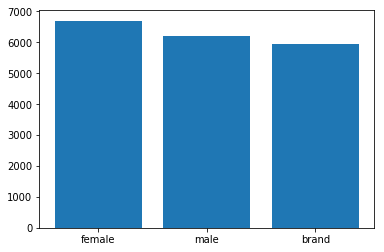

In [26]:
plt.bar(range(len(gender_dic)), list(gender_dic.values()), align='center')
plt.xticks(range(len(gender_dic)), list(gender_dic.keys()))
plt.show()

In [31]:
# replace all special/generic characters/words to get count metrics
def cleaning(s):
    s = str(s) #s.encode('utf-8').strip()
    s = s.lower()
    s = re.sub('\s\W',' ',s) 
    s = re.sub('\W,\s',' ',s) 
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", " ", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', ' ', s) 
    s = s.replace("co"," ")
    s = s.replace("https"," ")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s

df['text_norm'] = [cleaning(s) for s in df['text']]

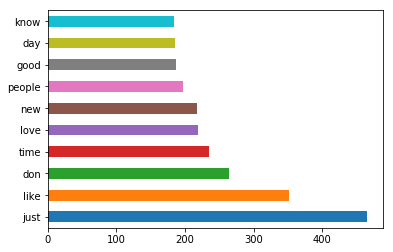

In [49]:
# get metrix of words for male users
male=df[df['gender']=='male']
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(male['text_norm'])
vectorizer.transform(male['text_norm']).todense()
X_train = pd.DataFrame(vectorizer.transform(male['text_norm']).todense(),
                       columns=vectorizer.get_feature_names())
word_counts = X_train.sum(axis=0)
word_counts.sort_values(ascending = False).head(10).plot.barh()

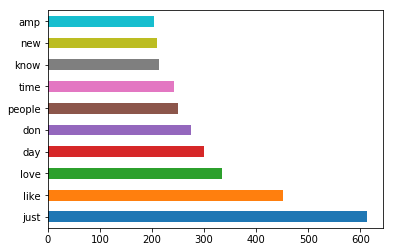

In [53]:
# get metrix of words for female users
female=df[df['gender']=='female']
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(female['text_norm'])
vectorizer.transform(male['text_norm']).todense()
X_train = pd.DataFrame(vectorizer.transform(female['text_norm']).todense(),
                       columns=vectorizer.get_feature_names())
word_counts = X_train.sum(axis=0)
word_counts.sort_values(ascending = False).head(10).plot.barh()

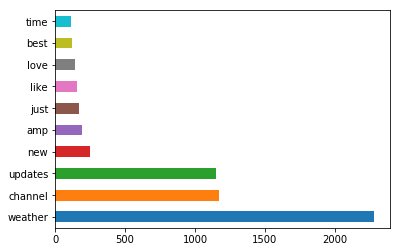

In [55]:
brand=df[df['gender']=='brand']
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(brand['text_norm'])
X_train = pd.DataFrame(vectorizer.transform(brand['text_norm']).todense(),
                       columns=vectorizer.get_feature_names())
word_counts = X_train.sum(axis=0)
word_counts.sort_values(ascending = False).head(10).plot.barh()